In [2]:
from __future__ import division
import time
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2 
from util import *
from darknet import Darknet
from preprocess import prep_image, inp_to_image, letterbox_image
import pandas as pd
import random 
import pickle as pkl
import argparse

In [28]:
def get_test_input(input_dim, CUDA):
    img = cv2.imread("dog-cycle-car.png")
    img = cv2.resize(img, (input_dim, input_dim)) 
    img_ =  img[:,:,::-1].transpose((2,0,1))
    img_ = img_[np.newaxis,:,:,:]/255.0
    img_ = torch.from_numpy(img_).float()
    img_ = Variable(img_)
    
    if CUDA:
        img_ = img_.cuda()
    
    return img_

def prep_image(img, inp_dim):
    """
    Prepare image for inputting to the neural network. 
    
    Returns a Variable 
    """

    orig_im = img
    dim = orig_im.shape[1], orig_im.shape[0]
    img = (letterbox_image(orig_im, (inp_dim, inp_dim)))
    img_ = img[:,:,::-1].transpose((2,0,1)).copy()
    img_ = torch.from_numpy(img_).float().div(255.0).unsqueeze(0)
    return img_, orig_im, dim

def write(x, img):
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    cls = int(x[-1])
    label = "{0}".format(classes[cls])
    color = random.choice(colors)
    cv2.rectangle(img, c1, c2,color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1);
    return img

In [19]:
class Options:
    confidence = .5
    nms_thresh = .4
    cfgfile = 'cfg/yolov3.cfg'
    weightsfile = './yolov3.weights'
    reso = 416

In [20]:
args = Options()

In [21]:
confidence = float(args.confidence)
nms_thesh = float(args.nms_thresh)
start = 0
num_classes = 80
CUDA = torch.cuda.is_available()

In [22]:
bbox_attrs = 5 + num_classes

In [23]:
model = Darknet(args.cfgfile)
model.load_weights(args.weightsfile)

In [24]:
model.net_info["height"] = args.reso

In [25]:
inp_dim = int(model.net_info["height"])

In [56]:
if CUDA:
    model.cuda()
model.eval()

In [32]:
image = cv2.imread("dog-cycle-car.png")

In [35]:
img, ori_img, dim = prep_image(image, inp_dim)

In [36]:
im_dim = torch.FloatTensor(dim).repeat(1,2)  

In [37]:
if CUDA:
    im_dim = im_dim.cuda()
    img = img.cuda()

In [38]:
with torch.no_grad():   
    output = model(Variable(img), CUDA)
output = write_results(output, confidence, num_classes, nms = True, nms_conf = nms_thesh)

In [41]:
im_dim = im_dim.repeat(output.size(0), 1)
scaling_factor = torch.min(inp_dim/im_dim,1)[0].view(-1,1)

output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim[:,0].view(-1,1))/2
output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim[:,1].view(-1,1))/2

output[:,1:5] /= scaling_factor

for i in range(output.shape[0]):
    output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim[i,0])
    output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim[i,1])

In [45]:
classes = load_classes('data/coco.names')
colors = pkl.load(open("pallete", "rb"))

g = list(map(lambda x: write(x, ori_img), output))

In [51]:
from PIL import Image
from IPython.display import display

def show(ary):
    display(Image.fromarray(ary))

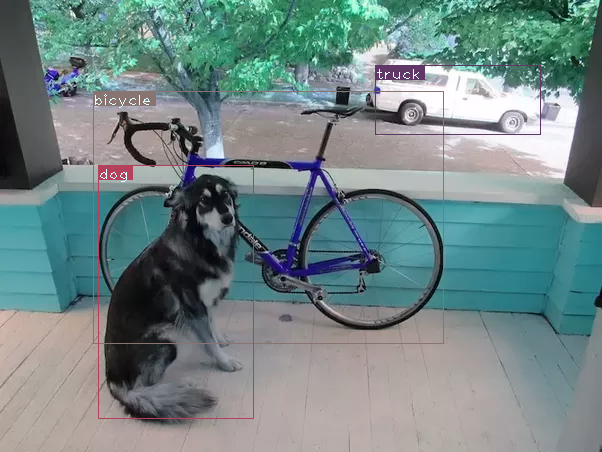

In [55]:
show(ori_img)